**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2025*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker

import seaborn
seaborn.set_context('talk')

from sqlalchemy import create_engine, text

In [2]:
import plotly
plotly.__version__


'6.1.0'

In [ ]:
airbnb_df = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')
airbnb_df.columns

In [3]:
# # data source: Melbourne 
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

# data source: Airbnb-Melbourne
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

/var/folders/9x/sk5wzh9n465bsgp0vntddj3w0000gn/T/ipykernel_85271/3089177150.py:13: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pd.read_csv(


## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Validar tipos de columnas antes de guardar: df.to_sql() infiere tipos automáticamente, pero a veces los nombres de columnas como Date, Price o ID dan problemas si vienen con strings o valores nulos.

4. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.
    - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
    - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



### Pequena exploracion de datos de las bases **melf_df**, **airnbnb_df**

Realizamos una pequena exploracion de los dataframes *melf_df* y *airbnb_df*, y entendemos que las bases de datos, mismo que puedan ser relacionadas, se encuentran con diferentes niveles de informaciones. La base *melf_df* es una base con nivel de informacion de precios de ventas de inmuebles de diversos barrios en la ciudad de Melbourne, Australia (entendemos que el campo 'suburb' puede ser considerado el barrio segun la siguiente pagina de referencia de https://www.melbourne.vic.gov.au/suburbs-and-neighbourhoods), mientras que la base *airbnb_df* tiene informacion de alquiler de diarios/semanal/mensual de diferentes ciudades Australia, incluyendo Melbourne. Tambien consideramos y entendemos que cada registro de la base puede tener un 'unique_id' para cada inmueble que puede ser considerado el campo 'Postcode', mientras que en la base *airbnb_df* ese campo seria 'zipcode', porque lo que podemos conectar ambas las fuentes considerando mediante estos campos. Pero como en algunas de las preguntas necesitamos responder y dar informaciones sobre cantidade de habitaciones, precio promedio de las propiedades o las propiedades mas caras, si realizamos un JOIN entre las bases vamos a terminando con informacion solamente para la ciudad de Melbourne y esto es debido a que la base airbnb generada en clase no tiene la informacion de la cantidad de habitaciones, tipo, precio de venta de inmueble, por esta razon consideramos trabajar directamente con la base *melf_df*, para responder las preguntas del apartado 3.


**Nota:** Realizamos una pequena exploracion de otros columnas que estan presentes en la base de datos 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv' y podemos ver que tiene informacion complementar que no fue considera en la clase como por ejemplo la cantidad de habitaciones, banos, etc. Por exemplo: 

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighborhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode','smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'requires_license', 'license', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month']


Creacion de Base de datos e ingesta

In [ ]:
# Create a SQLite database -- engine

engine = create_engine("sqlite:///melbourne.db", echo=True)

# Working data for the analysis
airbnb_df['zipcode'] = pd.to_numeric(airbnb_df.zipcode, errors='coerce')
airbnb_df['zipcode_int'] = airbnb_df.zipcode.fillna(0).astype('int') # Convertimos la columna zipcode a int y renombramos la columna para no perder la original
melb_df['Postcode'] = pd.to_numeric(melb_df.Postcode, errors='coerce')
melb_df['Postcode_int'] = melb_df.Postcode.fillna(0).astype('int') # Convertimos la columna Postcode a int y renombramos la columna para no perder la original
airbnb_df['weekly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*7. if pd.isnull(row['weekly_price']) else row['weekly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*7dias
airbnb_df['monthly_price_calculate'] = airbnb_df.apply(lambda row: row['price']*30. if pd.isnull(row['monthly_price']) else row['monthly_price'], axis=1) # Realizamos el calculo de weekly_price considerando price*30dias
airbnb_df['zipcode'] = pd.to_numeric( airbnb_df.zipcode, errors='coerce') 
melb_df['Date'] = pd.to_datetime(melb_df['Date'], errors='coerce') # Convertimos la columna Date a datetime
melb_df['Bedroom2'] = melb_df['Bedroom2'].fillna(0).astype('int') # Convertimos la columna Bedroom2 a int
melb_df['Bathroom'] = melb_df['Bathroom'].fillna(0).astype('int') # Convertimos la columna Bathroom a int
melb_df['Car'] = melb_df['Car'].fillna(0).astype('int') # Convertimos la columna Car a int


In [5]:
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         13580 non-null  object        
 1   Address        13580 non-null  object        
 2   Rooms          13580 non-null  int64         
 3   Type           13580 non-null  object        
 4   Price          13580 non-null  float64       
 5   Method         13580 non-null  object        
 6   SellerG        13580 non-null  object        
 7   Date           5138 non-null   datetime64[ns]
 8   Distance       13580 non-null  float64       
 9   Postcode       13580 non-null  float64       
 10  Bedroom2       13580 non-null  int64         
 11  Bathroom       13580 non-null  int64         
 12  Car            13580 non-null  int64         
 13  Landsize       13580 non-null  float64       
 14  BuildingArea   7130 non-null   float64       
 15  YearBuilt      8205

In [6]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   description              22563 non-null  object 
 1   neighborhood_overview    14424 non-null  object 
 2   street                   22895 non-null  object 
 3   neighborhood             17082 non-null  object 
 4   city                     22895 non-null  object 
 5   suburb                   22872 non-null  object 
 6   state                    22834 non-null  object 
 7   zipcode                  22749 non-null  float64
 8   latitude                 22895 non-null  float64
 9   longitude                22895 non-null  float64
 10  price                    22895 non-null  int64  
 11  weekly_price             2524 non-null   float64
 12  monthly_price            1891 non-null   float64
 13  zipcode_int              22895 non-null  int64  
 14  weekly_price_calculate

In [8]:
# Create a table 'melb' in the SQLite database
melb_df.to_sql('melb', con=engine, if_exists='replace', index=False)

2025-05-17 13:18:21,022 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-17 13:18:21,032 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-17 13:18:21,033 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:21,035 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-17 13:18:21,035 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:21,036 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-17 13:18:21,036 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:21,039 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-17 13:18:21,039 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:21,040 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("melb")
2025-05-17 13:18:21,040 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:21,0

13580

In [9]:
# Create a table 'airbnb' in the SQLite database and insert the data
airbnb_df.to_sql('airbnb', con=engine, if_exists='replace', index=False)

2025-05-17 13:18:22,101 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-17 13:18:22,137 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("airbnb")
2025-05-17 13:18:22,138 INFO sqlalchemy.engine.Engine [raw sql] ()


2025-05-17 13:18:22,140 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("airbnb")
2025-05-17 13:18:22,141 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:22,142 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-17 13:18:22,143 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:22,144 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-17 13:18:22,144 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:22,145 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("airbnb")
2025-05-17 13:18:22,146 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:18:22,146 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type in ('table', 'view')
2025-05-17 13:18:22,147 INFO sqlalchemy.engine.En

22895

Vimos que los datos cuando fueron guardados en la base de datos SQLite usando a estrutura interna de Pandas, algunos campos como 'Date', 'Bathroom2', 'Car', 'Bathroom' fueron en formatos que no fueron especificados. Por esa realizamos algunas modificaciones previamente en esos campos para poder guardarlos en un formato mas apto para cada campo. Tambien, pudimos observar en la documentacion de pandas que existe una parametro (dtype={'name_column1':Integer(), 'name_column2':Float(),.....}) que puede ser pasado en el momento de guardar los datos especificando los formatos de cada campo.

In [2]:
# Para saber el schema de la tabla melb
pd.read_sql(text("""select sql from sqlite_schema where name = 'melb'"""), con=engine)

NameError: name 'pd' is not defined

In [23]:
queryTotalRegistrosPorCiudad = "select count(*) as total from melb"
resultTotalRegistrosPorCiudad = pd.read_sql(queryTotalRegistrosPorCiudad, con=engine)
resultTotalRegistrosPorCiudad

2025-05-17 13:22:59,991 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-17 13:22:59,992 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total from melb")
2025-05-17 13:22:59,992 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:22:59,994 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total from melb")
2025-05-17 13:22:59,995 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:22:59,996 INFO sqlalchemy.engine.Engine select count(*) as total from melb
2025-05-17 13:22:59,997 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:22:59,998 INFO sqlalchemy.engine.Engine ROLLBACK


,total
0,13580


In [24]:
queryTotalRegistrosPorBarrioYCiudad = "select count(*) as total, suburb from melb group by suburb order by total desc;"
resultTotalRegistrosPorBarrioYCiudad = pd.read_sql(queryTotalRegistrosPorBarrioYCiudad, con=engine)
resultTotalRegistrosPorBarrioYCiudad

2025-05-17 13:23:18,567 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-17 13:23:18,569 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, suburb from melb group by suburb order by total desc;")
2025-05-17 13:23:18,571 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:23:18,573 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, suburb from melb group by suburb order by total desc;")
2025-05-17 13:23:18,573 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:23:18,575 INFO sqlalchemy.engine.Engine select count(*) as total, suburb from melb group by suburb order by total desc;
2025-05-17 13:23:18,575 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:23:18,588 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Suburb
0,359,Reservoir
1,260,Richmond
2,249,Bentleigh East
3,239,Preston
4,222,Brunswick
...,...,...
309,1,Bullengarook
310,1,Brookfield
311,1,Beaconsfield Upper
312,1,Bacchus Marsh


In [25]:
    # - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    
queryTotalRegistrosPorCiudadConMasDe2Habitaciones = "select count(*) as total from melb where rooms > 2 order by total desc;"
resultTotalRegistrosPorCiudadConMasDe2Habitaciones = pd.read_sql(queryTotalRegistrosPorCiudadConMasDe2Habitaciones, con=engine)
resultTotalRegistrosPorCiudadConMasDe2Habitaciones


2025-05-17 13:23:44,016 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-17 13:23:44,017 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total from melb where rooms > 2 order by total desc;")
2025-05-17 13:23:44,018 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:23:44,026 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total from melb where rooms > 2 order by total desc;")
2025-05-17 13:23:44,029 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:23:44,031 INFO sqlalchemy.engine.Engine select count(*) as total from melb where rooms > 2 order by total desc;
2025-05-17 13:23:44,032 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-17 13:23:44,045 INFO sqlalchemy.engine.Engine ROLLBACK


,total
0,9251


In [26]:
    # - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
queryPrecioPromedioPorTipoYCiudad = "select round(avg(price) ,2) as precio_promedio, type  from melb group by type order by precio_promedio desc;"
resultPrecioPromedioPorTipoYCiudad = pandas.read_sql(queryPrecioPromedioPorTipoYCiudad, con=engine)
resultPrecioPromedioPorTipoYCiudad

NameError: name 'pandas' is not defined

In [56]:
    # - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.
queryTop5BarriosConPropiedadesMasCaras = "select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;"
resultTop5BarriosConPropiedadesMasCaras = pandas.read_sql(queryTop5BarriosConPropiedadesMasCaras, con=engine)
resultTop5BarriosConPropiedadesMasCaras


2025-05-16 01:07:07,038 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-16 01:07:07,039 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-16 01:07:07,040 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:07,041 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-16 01:07:07,042 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:07,043 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;
2025-05-16 01:07:07,043 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:07,055 INFO sqlalchemy.engine.Engine ROLLBACK


,precio_promedio,Suburb
0,2185000.00,Kooyong
1,2180240.74,Canterbury
2,2082529.41,Middle Park
3,1941355.07,Albert Park
4,1930158.00,Brighton


Ejercicio 5

In [ ]:
queryJoin = "select m.*, a* from melb m left join airbnb a on m.postcode = a.zipcode"
resultJoin = pandas.read_sql(queryJoin, con=engine)
resultJoin

2025-05-16 01:07:07,070 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-16 01:07:07,071 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:07,071 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:07,073 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:07,073 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:07,074 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-16 01:07:07,076 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:08,756 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,weekly_price,monthly_price
0,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
1,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
2,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
3,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
4,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188870,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,980.00,4001.00
188871,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,1070.00,3672.00
188872,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,1495.00,5550.00
188873,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,1700.00,3900.00


## Ejercicio 2 - Pandas:

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.
  1. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
  2.  Mostrar la dispersión o distribución de las columnas seleccionadas.
 3.  Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.
 4. Mostrar visualmente los valores extremos que eliminás



2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
  2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  3. Mostrar un gráfico zipcode vs airbnb_price_median.
  4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
  5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

In [58]:
#1 -Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.

#Vamos a utilizar la columnas Price, Rooms, Bedroom2 y bathroom ya que tienen una buena correlacion con el precio de las propiedades

correlaciones = pandas.read_sql(queryJoin, con=engine).select_dtypes(include=[numpy.number]).corr().abs()
correlaciones['Price'].sort_values(ascending=False)

2025-05-16 01:07:08,986 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-16 01:07:08,987 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:08,987 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:08,988 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:08,989 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:08,990 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-16 01:07:08,990 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:10,674 INFO sqlalchemy.engine.Engine ROLLBACK


Price           1.00
Rooms           0.64
Bedroom2        0.63
Bathroom        0.52
YearBuilt       0.43
Car             0.32
BuildingArea    0.27
Propertycount   0.14
Longtitude      0.13
Postcode        0.13
Lattitude       0.07
Landsize        0.04
weekly_price    0.03
monthly_price   0.02
Distance        0.01
Name: Price, dtype: float64

In [59]:
# Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
rows = pandas.read_sql(queryJoin, con=engine)

totalValorFaltante = 0

for idx, fila in rows.iterrows():
    if fila.isnull().any():
        totalValorFaltante += 1
        continue

print(f"\nTotal de filas con al menos un valor faltante en su columna: {totalValorFaltante / len(rows) * 100:.2f}%")

2025-05-16 01:07:10,836 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-16 01:07:10,837 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:10,838 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:10,839 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:10,840 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:10,841 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-16 01:07:10,842 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:12,612 INFO sqlalchemy.engine.Engine ROLLBACK

Total de filas con al menos un valor faltante en su columna: 50.78%


2025-05-16 01:07:24,199 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-16 01:07:24,200 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:24,200 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:24,201 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-16 01:07:24,202 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:24,203 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-16 01:07:24,203 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:07:25,768 INFO sqlalchemy.engine.Engine ROLLBACK


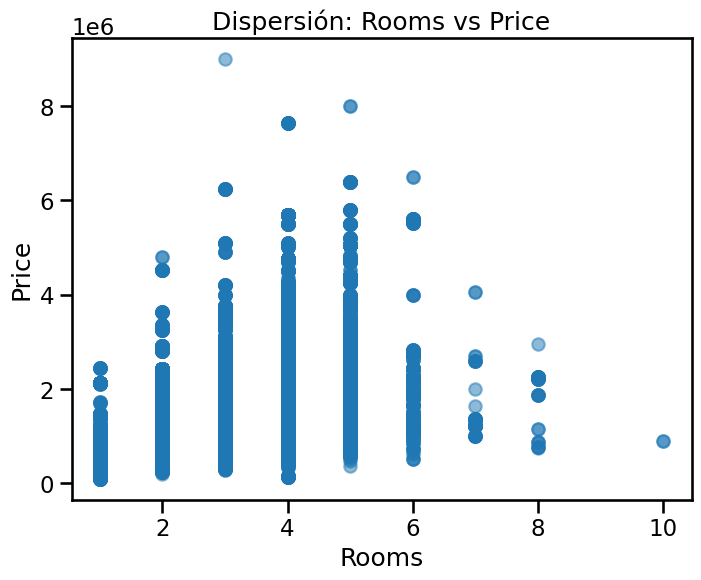

In [60]:
columnasSeleccionadas = ['Price', 'Rooms', 'Bedroom2', 'Bathroom']
result = pandas.read_sql(queryJoin, con=engine)[columnasSeleccionadas]

plt.figure(figsize=(8, 6))
plt.scatter(result['Rooms'], result['Price'], alpha=0.5)
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Dispersión: Rooms vs Price')
plt.show()



In [61]:
result.sort_values(by='Price', ascending=True)


,Price,Rooms,Bedroom2,Bathroom
32726,85000.00,1,1.00,1.00
32734,85000.00,1,1.00,1.00
32733,85000.00,1,1.00,1.00
32732,85000.00,1,1.00,1.00
32731,85000.00,1,1.00,1.00
...,...,...,...,...
150795,7650000.00,4,4.00,2.00
150791,7650000.00,4,4.00,2.00
124710,8000000.00,5,5.00,5.00
124709,8000000.00,5,5.00,5.00


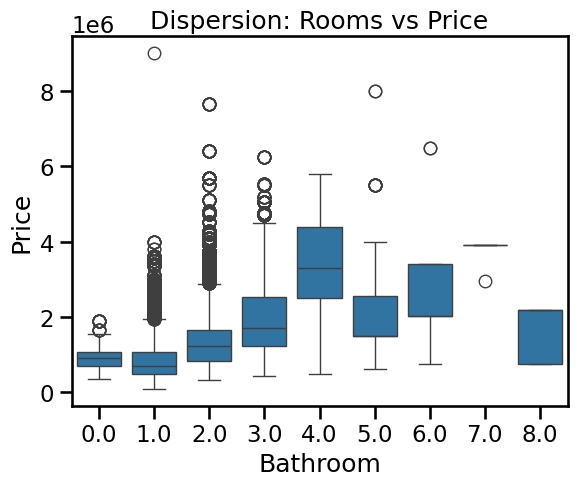

In [62]:
seaborn.boxplot(x='Bathroom', y='Price', data=result)
plt.title('Dispersion: Rooms vs Price')
plt.show()

2025-05-16 01:10:19,855 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-16 01:10:19,856 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 800000.0")
2025-05-16 01:10:19,857 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:10:19,858 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 800000.0")
2025-05-16 01:10:19,860 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:10:19,861 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 800000.0
2025-05-16 01:10:19,862 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-16 01:10:20,697 INFO sqlalchemy.engine.Engine ROLLBACK


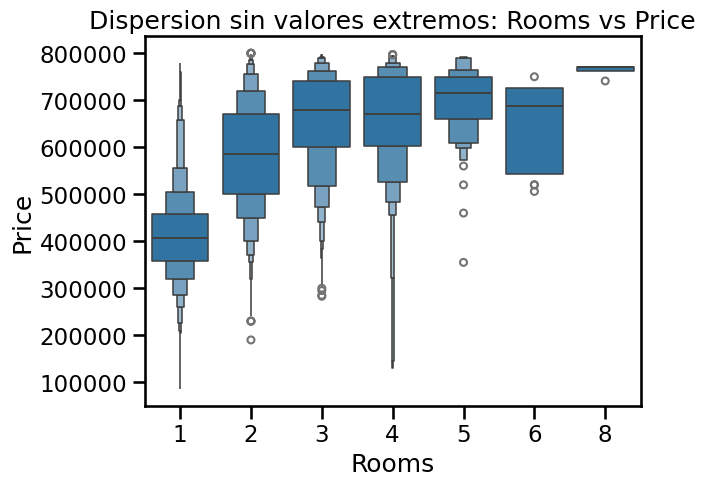

In [69]:
#Eliminar valores atípicos de propiedades con valores mayor a 6 millone

pandas.set_option('display.float_format', lambda x: '%.2f' % x)
quantile=  resultJoin['Price'].quantile(0.90)


queryJoin = "select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < "+ str(quantile)    

resultJoin = pandas.read_sql(queryJoin, con=engine)

ax = seaborn.boxenplot(x='Rooms', y='Price', data=resultJoin)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.title('Dispersion sin valores extremos: Rooms vs Price')
plt.show()

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)